In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Unzip data to session drive
# !unzip -u "/content/gdrive/MyDrive/Biomed_Assignment1_Data.zip" -d "/content"
!unzip -q -u "/content/gdrive/MyDrive/tiny_Data.zip" -d "/content/"

In [34]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import os
import cv2
import random

from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9198074096520482043
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14401011712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1000763342606451486
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
# Setup
fold_num = 1

# Image Size
img_width, img_height, img_depth = 128, 128, 3
data_dir = Path('/content/Data_Small')
data_dir_train = data_dir / 'train'
data_dir_test = data_dir / 'test'

epochs = 10
freq = 20
batch_size = 40
num_classes = 2
train_valid_split = 0.2

class_weights = {0: 2.,
                1: 1.,
                2: 1.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'
print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax


*Explanation of hyperparameters*

Epochs: I first trained with 5 max epochs, which resulted in cutting off the max learning potential (loss was still decreasing). Increased to 10, which resulted in reaching close to absolute minimum.

Learning rate: Based on the example code given, I used the same learning rate as it performed well for this case based on the loss plot below. It may have been possible to get a smoother loss descent with a smaller learning rate, but that would require much more epochs.

Batch Size: With the default batch size of 32, my training worked well but the loss plot was quite eratic. Since I had more VRAM available, I increased the batch size to allow the calculated loss to encapsulate more data samples.

## Creating custom DataGenerator

### Make CSV with datapath and ground truths

In [5]:
train_dir_list = os.listdir(data_dir_train)
test_dir_list = os.listdir(data_dir_test)
print ('Train Classes: ', train_dir_list)
print ('Test Classes: ', test_dir_list)

Train Classes:  ['DRUSEN', 'DME']
Test Classes:  ['DRUSEN', 'DME']


In [6]:
index_labels = {'DRUSEN':0, 'DME':1}

In [7]:
# Dataframes for holding train and test set CSVs
train_df = pd.DataFrame(columns=['File', 'Label', 'ClassName'])
val_df = pd.DataFrame(columns=['File', 'Label', 'ClassName'])

test_df = pd.DataFrame(columns=['File', 'Label', 'ClassName'])

In [8]:
# TRAIN: Load image names and ground truths into cv2
for directory in train_dir_list:
  # Load file names of each image in training set
  train_files = os.listdir(os.path.join(data_dir_train, directory))
  # Progress Statement for loading images
  print ('Loading the images of dataset-'+'{}\n'.format(directory))
  index_label = index_labels[directory]
  num_files = len(train_files)
  # 20% of train set will be validation set
  val_index = random.sample(range(1, num_files-1), (int(num_files * 0.2)))
  
  for i in range(num_files):
    name = train_files[i]
    filename = os.path.join(data_dir_train, directory, name)

    input = cv2.imread(filename)
    shape = input.shape
    if i in val_index:
      val_df = val_df.append({'File': filename, 'Label': index_label, 'ClassName': directory}, ignore_index=True)
    else:
      train_df = train_df.append({'File': filename, 'Label': index_label, 'ClassName': directory}, ignore_index=True)
  
  print('{0} images found from {1} directory\n'.format(num_files, directory))

# TEST: Load image names and ground truths into cv2
for directory in test_dir_list:
  # Load file names of each image in training set
  test_files = os.listdir(os.path.join(data_dir_test, directory))
  # Progress Statement for loading images
  print ('Loading the images of dataset-'+'{}\n'.format(directory))
  index_label = index_labels[directory]
  num_files = len(test_files)
  
  for i in range(num_files):
    name = test_files[i]
    filename = os.path.join(data_dir_test, directory, name)

    input = cv2.imread(filename)
    shape = input.shape
    test_df = test_df.append({'File': filename, 'Label': index_label, 'ClassName': directory}, ignore_index=True)
  
  print('{0} images found from {1} directory\n'.format(num_files, directory))

Loading the images of dataset-DRUSEN

1024 images found from DRUSEN directory

Loading the images of dataset-DME

1510 images found from DME directory

Loading the images of dataset-DRUSEN

213 images found from DRUSEN directory

Loading the images of dataset-DME

301 images found from DME directory



In [9]:
csv_dir = '/content/Data_Small/CSVs'
if not os.path.exists(csv_dir):
  os.mkdir(csv_dir)
train_df.to_csv(csv_dir + '/train.csv')
test_df.to_csv(csv_dir + '/test.csv')
print('Train and Test CSVs have been created')

Train and Test CSVs have been created


#### Method 1

In [26]:
class DataGen_seq(tf.keras.utils.Sequence):
  def __init__(self, df, x_col, y_col, batch_size,
                 input_size=(img_height, img_width, img_depth),
                 shuffle=True,
                 aug=True):    
    self.df = df.copy()
    self.x_col = x_col
    self.y_col = y_col
    self.batch_size = batch_size
    self.input_size = input_size
    self.shuffle = shuffle
    self.aug = aug
    
    self.length = len(self.df)
    self.label = df[y_col['Label']].nunique()

  def on_epoch_end(self):
    # Shuffle data after every epoch
    if self.shuffle:
      self.df = self.df.sample(frac=1).reset_index(drop=True)
  
  def __getInput(self, dir, size, aug):
    # Load and convert image to NumPy array for compatibility
    img = tf.keras.preprocessing.image.load_img(dir)
    img_arr = tf.keras.preprocessing.image.img_to_array(img)

    # Preprocessing
    img_arr = tf.image.resize(img_arr, (size[0], size[1])).numpy()
    if aug:
      img_arr = tf.image.rot90(img_arr, k=random.randint(1, 4))

    return img_arr/255.

  def __getOutput(self, label, num_classes):
    # Return one-hot encoded NumPy array of labels of the size: num_classes
    return tf.keras.utils.to_categorical(label, num_classes=num_classes)

  def __getData(self, batches):
    batch_path = batches[self.x_col['File']]
    batch_label = batches[self.y_col['Label']]

    x_batch = np.asarray([self.__getInput(x, self.input_size, self.aug) for x in batch_path])
    y_batch = np.asarray([self.__getOutput(y, self.label) for y in batch_label])

    return x_batch, y_batch
  # Load sample and perform preprocessing
  def __getitem__(self, index):
      batches = self.df[index * self.batch_size:(index+1) * self.batch_size]
      x, y = self.__getData(batches)
      return x, y

  def __len__(self):
      return self.length // self.batch_size

In [11]:
# Check what train_df is
train_df

,File,Label,ClassName
0,/content/Data_Small/train/DRUSEN/DRUSEN-457907...,0,DRUSEN
1,/content/Data_Small/train/DRUSEN/DRUSEN-466465...,0,DRUSEN
2,/content/Data_Small/train/DRUSEN/DRUSEN-783692...,0,DRUSEN
3,/content/Data_Small/train/DRUSEN/DRUSEN-117325...,0,DRUSEN
4,/content/Data_Small/train/DRUSEN/DRUSEN-107751...,0,DRUSEN
...,...,...,...
2023,/content/Data_Small/train/DME/DME-633268-44.jpeg,1,DME
2024,/content/Data_Small/train/DME/DME-1920087-8.jpeg,1,DME
2025,/content/Data_Small/train/DME/DME-993691-3.jpeg,1,DME
2026,/content/Data_Small/train/DME/DME-671384-9.jpeg,1,DME


In [62]:
train_generator = DataGen_seq(train_df,
                              x_col={'File':'File'},
                              y_col={'Label':'Label'},
                              batch_size=batch_size,)
valid_generator = DataGen_seq(val_df,
                              x_col={'File':'File'},
                              y_col={'Label':'Label'},
                              batch_size=batch_size,
                              aug=False)
test_generator = DataGen_seq(test_df,
                             x_col={'File':'File'},
                             y_col={'Label':'Label'},
                             batch_size=len(test_df),
                             aug=False)

#### Method 2

In [ ]:
from sklearn.utils import shuffle
import random

In [ ]:
# Rotate image function
def rotate_img(img, angle):
  img_center = tuple(np.array(img.shape[1::-1])/2)
  rotate_matrix = cv2.getRotationMatrix2D(img_center, angle, 1.0)
  result = cv2.warpAffine(img, rotate_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [ ]:
def DataGen(samples, batch_size=32, shuffle_data=True, height=img_height, width=img_width):
  num_of_samples = len(samples)
  while True:
    samples = shuffle(samples)
    
    for batch_offset in range(0, num_of_samples, batch_size):
      # Load samples into the #-sized batch
      batch_samples = samples[batch_offset:batch_offset + batch_size]

      x_batch = []
      y_batch = []
      for batch_sample in batch_samples:
        # Load image and label
        name = batch_sample[0]
        label = batch_sample[1]
        img = cv2.imread(os.path.join(data_dir, name))

        # Preprocessing
        # Resize
        img = cv2.resize(img,(height, width))
        # Rotation
        # img = cv2.rotate_img(img, random.randint(-20, 20))

        # After preprocessing, add to batch arrays
        x_batch.append(img)
        y_batch.append(label)
      x_batch = np.array(x_batch)
      y_batch = np.array(y_batch)

      yield x_batch, y_batch

In [ ]:
# Function: Load samples from CSV
def LoadSamp(csv_file):
  data = pd.read_csv(os.path.join('',csv_file))
  data = data[['File', 'Label', 'ClassName']]
  filenames = list(data.iloc[:,0])
  labels = list(data.iloc[:,1])

  samples=[]
  for name,lab in zip(filenames,labels):
    samples.append([name,lab])
  return samples

In [ ]:
# Load samples from CSVs for train and test
train_csv_dir = csv_dir + '/train.csv'
test_csv_dir = csv_dir + '/test.csv'
train_samples = LoadSamp(train_csv_dir)
test_samples = LoadSamp(test_csv_dir)

print(train_samples[0:5])

[['/content/Data_Small/train/DRUSEN/DRUSEN-464044-9.jpeg', 0], ['/content/Data_Small/train/DRUSEN/DRUSEN-1077513-1.jpeg', 0], ['/content/Data_Small/train/DRUSEN/DRUSEN-464044-3.jpeg', 0], ['/content/Data_Small/train/DRUSEN/DRUSEN-552350-8.jpeg', 0], ['/content/Data_Small/train/DRUSEN/DRUSEN-1016042-6.jpeg', 0]]


In [ ]:
# Create DataGen object
train_generator = DataGen()

## 2: Data (Not Adapted for A2)

In [46]:
img_height = 128
img_width = 128

# # Method 1: image_dataset_from_directory
# data_dir_DME = Path('/content/Data_Small/train/')
# train_df = tf.keras.utils.image_dataset_from_directory(
#     data_dir_DME,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )
# val_df = tf.keras.utils.image_dataset_from_directory(
#     data_dir_DME,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# # Method 2: ImageDataGenerator (MUST IMPLEMENT THIS WITH OWN VERSION)
# datagen = ImageDataGenerator(
#     rescale = 1./255,
#     horizontal_flip = True,
#     vertical_flip = True,
#     rotation_range = 90,
#     validation_split = 0.2,
#     fill_mode = 'constant')

# train_generator = datagen.flow_from_directory(
#     directory = '/content/Data_Small/train/',
#     class_mode = class_mode,
#     batch_size = batch_size,
#     target_size = (img_height, img_width),
#     subset = "training")

# valid_generator = datagen.flow_from_directory(
#     directory = '/content/Data_Small/train/',
#     class_mode = class_mode,
#     batch_size = batch_size,
#     target_size = (img_height, img_width),
#     subset = "validation",
#     shuffle = False)

In [ ]:
class_names = train_generator.class_indices
print(class_names)

{'DME': 0, 'DRUSEN': 1}


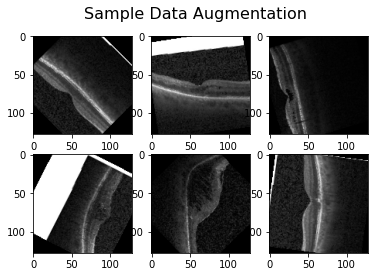

y Labels:  [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [ ]:
#For Directory
#Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

## 3: Training

##### Train your model using

In [ ]:
# To prevent dataset bottleneck, keep images in memory and 
#   preprocess data while executing model during training
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
# val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
gdrive_dir = '/content/gdrive/MyDrive/Biomed AI'

In [13]:
# Build model
image_input = Input(shape = (img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                      include_top = False,
                                      weights = 'imagenet')
base_output = base_model.layers[-1].output

flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation = act_type)(dropfc2)

for layer in base_model.layers[:-9]:
  layer.trainable = False

model = Model(image_input, output)

58889256/58889256 [==============================] - 3s 0us/step


In [14]:
# Compile the model
opt = Adam(learning_rate = 0.00001)
model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy'])

In [15]:
from dummy_threading import current_thread
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, period = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [28]:
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              steps_per_epoch = train_generator.length // batch_size,
                              validation_data = valid_generator,
                              validation_steps = valid_generator.length // batch_size,
                              callbacks = [check, tensor_board],
                              class_weight = class_weights)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)
hist_df = pd.DataFrame(history.history)

<ipython-input-28-0fd0bedd140a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
50/50 [==============================] - 26s 523ms/step - loss: 1.2450 - accuracy: 0.4525 - val_loss: 0.7743 - val_accuracy: 0.4250
Epoch 2/10
50/50 [==============================] - 26s 513ms/step - loss: 1.0310 - accuracy: 0.5170 - val_loss: 0.6097 - val_accuracy: 0.6458
Epoch 3/10
50/50 [==============================] - 27s 541ms/step - loss: 0.6632 - accuracy: 0.7490 - val_loss: 0.5142 - val_accuracy: 0.7500
Epoch 4/10
50/50 [==============================] - 27s 546ms/step - loss: 0.3648 - accuracy: 0.8725 - val_loss: 0.2658 - val_accuracy: 0.8792
Epoch 5/10
50/50 [==============================] - 32s 637ms/step - loss: 0.2680 - accuracy: 0.9155 - val_loss: 0.2175 - val_accuracy: 0.9000
Epoch 6/10
50/50 [==============================] - 25s 509ms/step - loss: 0.2390 - accuracy: 0.9225 - val_loss: 0.1701 - val_accuracy: 0.9229
Epoch 7/10
50/50 [==============================] - 26s 518ms/step - loss: 0.1992 - accuracy: 0.9370 - val_loss: 0.2473 - val_accuracy: 0.8979

In [ ]:
model.save('/content/gdrive/MyDrive/Biomed AI/10epoch_model')

In [18]:
# Save history
# np.save('10epoch_hist.npy', history.history)
# history.history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/gdrive/MyDrive/Biomed AI/10epoch_hist.csv')

In [ ]:
# # Load Model
# model = tf.keras.models.load_model('/content/gdrive/MyDrive/Biomed AI/10epoch_model')
# model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# # Plot training and validation loss
# stats_df = pd.read_csv('/content/gdrive/MyDrive/Biomed AI/10epoch_hist.csv')
# stats_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,1.045777,0.583501,0.857778,0.629167
1,1,0.918416,0.620221,0.722819,0.633333
2,2,0.623900,0.761066,0.376969,0.825000
3,3,0.418422,0.866197,0.346826,0.870833
4,4,0.324159,0.894869,0.212213,0.908333
5,5,0.295158,0.906439,0.266612,0.897917
6,6,0.272669,0.915493,0.201055,0.914583
7,7,0.240861,0.926056,0.255602,0.908333
8,8,0.231335,0.926056,0.183989,0.920833
9,9,0.217301,0.930583,0.246455,0.889583


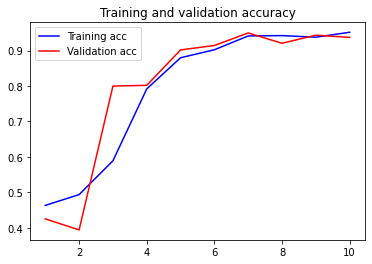

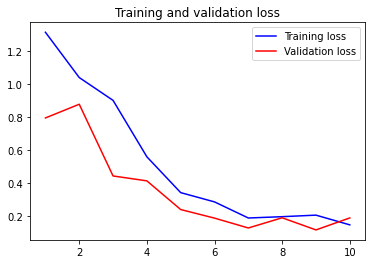

In [19]:
# Assign each loss/accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Confusion Matrix

### Old Method for A1

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [48]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')

test_generator_orig = test_datagen.flow_from_directory(
                              directory = '/content/Data_Small/test',
                              target_size = (img_width, img_height),
                              class_mode = class_mode,
                              batch_size = batch_size)

test_generator_orig.classes
# test_generator.__getOutput
test_generator_classes = np.asarray(test_df['Label'], dtype='int32')

Found 514 images belonging to 2 classes.


In [35]:
X, y_true = [], []
i = 0
while i < 30:
    temp_X, temp_y_true = test_generator.__getitem__
    if i < 1:
        X = temp_X
        y_true = temp_y_true
    else:
        X = np.concatenate((X, temp_X), axis=0)
        y_true = np.concatenate((y_true, temp_y_true), axis = 0)
    i += 1

print(np.shape(X))
print(np.shape(y_true))

y_pred = model.predict(X)

ValueError: ignored

Categorical Classification
---------------------
Normalized confusion matrix
[[0.975 0.025]
 [  nan   nan]]
[[39  1]
 [ 0  0]]


<ipython-input-20-fe6669293d13>:23: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


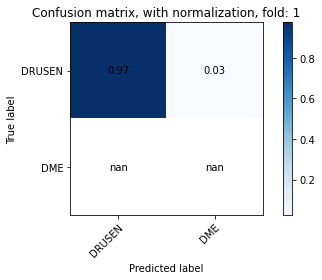

In [32]:
title_mat = 'Confusion matrix, with normalization, fold: ' + str(fold_num)
plot_name = name_dir + '/confusion_matrix_fold' + str(fold_num) + '.png'
print('Categorical Classification')
print('---------------------')
plot_confusion_matrix(y_true.argmax(axis=1),
                      y_pred.argmax(axis=1),
                      classes = index_labels,
                      normalize = True,
                      title = title_mat)
plt.savefig(plot_name)
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

### New Method for A2

In [63]:
# Different confusion matrix method
# Y_pred = model.predict_generator(test_generator, len(test_df) // batch_size+1)
Y_pred = model.predict(test_generator, batch_size=None)
y_pred = np.argmax(Y_pred, axis=1)
len(Y_pred)

1/1 [==============================] - 15s 15s/step


514

<function matplotlib.pyplot.show(*args, **kw)>

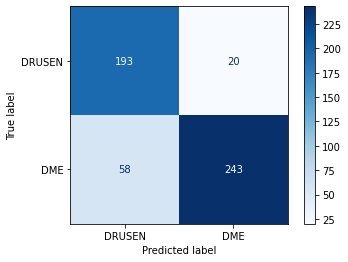

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = np.array(y_pred)
y_test = np.array(test_generator_classes)
labels = ["DRUSEN", "DME"]

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show